## AlexNet Model using Oxfordflower17 Image Data

In [172]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Rescaling, Dense, Conv2D, Activation, Dropout, MaxPooling2D, Flatten, RandomFlip, RandomRotation, RandomZoom, Dropout
from tensorflow.keras import layers

import pathlib
from time import time

In [23]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [20]:
img_height = 227
img_width = 227
batch_size = 32

In [40]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    label_mode='categorical',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.


In [44]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    label_mode='categorical',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


In [171]:
def plot_accuracy_loss(history, epochs):
    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.close('all')

In [167]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [168]:
# test model on new image
img_path = 'images/rose_test_img.jpeg'
img = tf.keras.utils.load_img(img_path, color_mode='rgb', target_size=(227, 227))
img_arr = tf.keras.utils.img_to_array(img)
img_arr = np.array([img_arr])

In [169]:
def get_new_image_predictions(model, img_arr):
    return model.predict(img_arr)

In [170]:
def plot_rose_predictions(img_prediction, class_names, model_name):
    min_pred = np.min(img_prediction[0])
    max_pred = np.max(img_prediction[0])
    scaled_pred = (img_prediction[0] - min_pred)/(max_pred - min_pred)

    fig, ax = plt.subplots()
    ax.bar(class_names, scaled_pred)
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Rose Prediction {model_name}')

    plt.show()
    plt.close('all')

# ------------ AlexNet Model ------------

In [49]:
# https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
def build_alexnet():
    K.clear_session()
    
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(227, 227, 3)))
    model.add(Conv2D(96, kernel_size=(11,11), strides=4, padding='valid', input_shape=(227, 227, 3), kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format= None))
    model.add(Conv2D(256, kernel_size=(5,5), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding='valid', data_format= None)) 
    model.add(Conv2D(384, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(384, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', data_format= None))
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dense(5, activation= 'softmax'))
    
    return model

In [50]:
model_alexnet = build_alexnet()
# stochastic gradient descent optimizer
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

start_time = time()
model_alexnet.compile(loss='categorical_crossentropy', optimizer=sgd, 
                   metrics=['accuracy','binary_accuracy','categorical_accuracy','categorical_crossentropy'])
end_time = time() - start_time
print(f'Alexnet Model took {end_time} seconds to compile & build')
# model_alexnet.summary()

Alexnet Model took 0.0029032230377197266 seconds to compile & build


In [173]:
model_alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 27, 27, 256)       0         
                                                        

In [51]:
start_time = time()
history_alexnet_model = model_alexnet.fit(train_ds, epochs=50, validation_data=val_ds, shuffle=True, verbose=0)
end_time = time() - start_time
print(f'Alexnet Model took {end_time} seconds to fit')

Alexnet Model took 2664.4273641109467 seconds to fit


In [151]:
start_time = time()
model_alexnet_score = model_alexnet.evaluate(val_ds, verbose=0)
end_time = time() - start_time
print(f'Alexnet Model took {end_time} seconds to score')

Alexnet Model took 9.796278953552246 seconds to score


In [156]:
model_alexnet_score_dict = dict(zip(model_alexnet.metrics_names, model_alexnet_score))
model_alexnet_score_dict

{'loss': 2.4260101318359375,
 'accuracy': 0.7157129645347595,
 'binary_accuracy': 0.8870118856430054,
 'categorical_accuracy': 0.7157129645347595,
 'categorical_crossentropy': 2.4260101318359375}

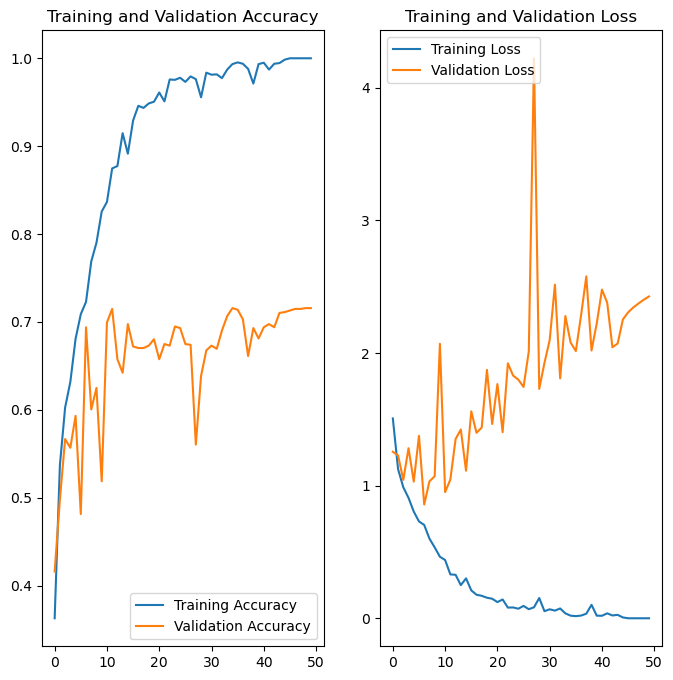

In [110]:
plot_accuracy_loss(history_alexnet_model, 50)

1/1 [==============================] - 0s 26ms/step


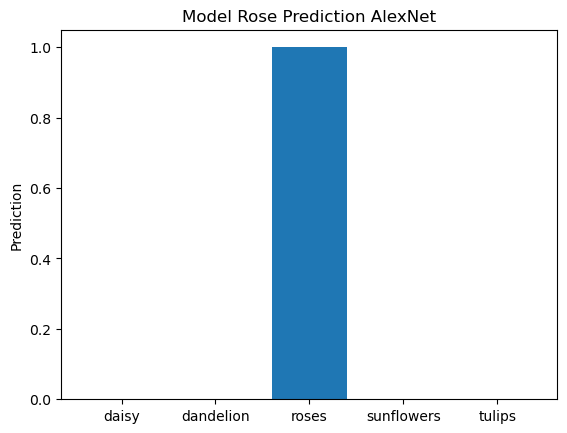

In [143]:
alex_net_prediction = get_new_image_predictions(model_alexnet, img_arr)
plot_rose_predictions(alex_net_prediction, class_names, 'AlexNet')

# ------------ AlexNet Model + Image Augmentation ------------

In [103]:
def build_alexnet_image_augmentation():
    K.clear_session()
    
    tf.random.set_seed(42)
    model = Sequential()
    # image augmentation
    model.add(RandomFlip("horizontal", input_shape=(227, 227, 3)))
    model.add(RandomRotation(0.1))
    model.add(RandomZoom(0.1))
    
    model.add(Rescaling(1./255, input_shape=(227, 227, 3)))
    model.add(Conv2D(96, kernel_size=(11,11), strides=4, padding='valid', input_shape=(227, 227, 3), kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format= None))
    model.add(Conv2D(256, kernel_size=(5,5), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding='valid', data_format= None)) 
    model.add(Conv2D(384, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(384, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', data_format= None))
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dense(5, activation= 'softmax'))
    
    return model

In [104]:
model_alexnet_aug = build_alexnet_image_augmentation()
# stochastic gradient descent optimizer
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

start_time = time()
model_alexnet_aug.compile(loss='categorical_crossentropy', optimizer=sgd, 
                   metrics=['accuracy','binary_accuracy','categorical_accuracy','categorical_crossentropy'])
end_time = time() - start_time
print(f'Alexnet Model Aug. took {end_time} seconds to compile & build')

Alexnet Model Aug. took 0.008446931838989258 seconds to compile & build


In [105]:
start_time = time()
history_alexnet_aug_model = model_alexnet_aug.fit(train_ds, epochs=50, validation_data=val_ds, shuffle=True, verbose=0)
end_time = time() - start_time
print(f'Alexnet Model Aug. took {end_time} seconds to fit')

Alexnet Model Aug. took 2707.2133247852325 seconds to fit


In [153]:
start_time = time()
model_alexnet_aug_score = model_alexnet_aug.evaluate(val_ds, verbose=0)
end_time = time() - start_time
print(f'Alexnet Aug Model took {end_time} seconds to score')

Alexnet Aug Model took 9.695109128952026 seconds to score


In [155]:
model_alexnet_aug_score_dict = dict(zip(model_alexnet_aug.metrics_names, model_alexnet_aug_score))
model_alexnet_aug_score_dict

{'loss': 1.014504313468933,
 'accuracy': 0.7465940117835999,
 'binary_accuracy': 0.9015441536903381,
 'categorical_accuracy': 0.7465940117835999,
 'categorical_crossentropy': 1.014504313468933}

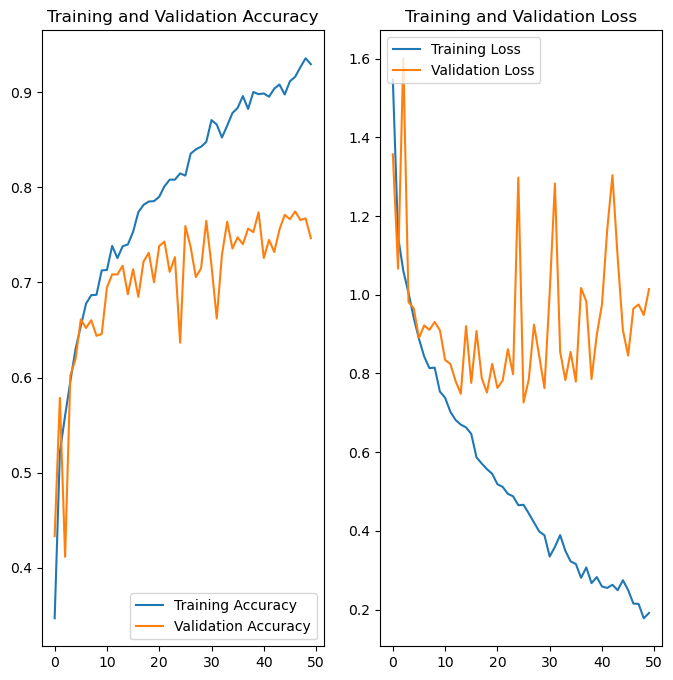

In [113]:
plot_accuracy_loss(history_alexnet_aug_model, 50)

1/1 [==============================] - 0s 28ms/step


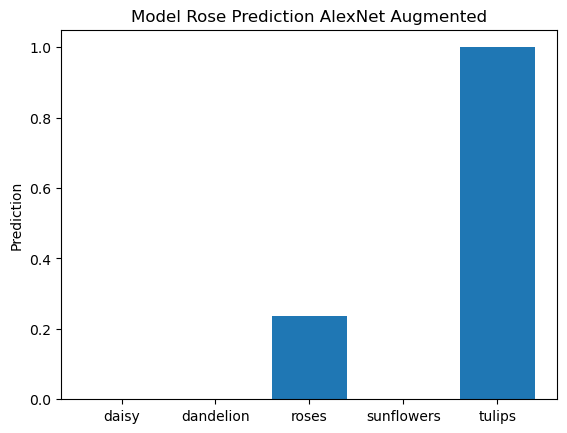

In [144]:
alexnet_aug_pediction = get_new_image_predictions(model_alexnet_aug, img_arr)
plot_rose_predictions(alexnet_aug_pediction, class_names, 'AlexNet Augmented')

# ---------- AlexNet Model + Image Augmentation + Dropout ----------

In [124]:
def build_alexnet_image_augmentation_dropout():
    K.clear_session()
    
    tf.random.set_seed(42)
    model = Sequential()
    # image augmentation
    model.add(RandomFlip("horizontal", input_shape=(227, 227, 3)))
    model.add(RandomRotation(0.1))
    model.add(RandomZoom(0.1))
    
    model.add(Rescaling(1./255, input_shape=(227, 227, 3)))
    model.add(Conv2D(96, kernel_size=(11,11), strides=4, padding='valid', input_shape=(227, 227, 3), kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format= None))
    model.add(Conv2D(256, kernel_size=(5,5), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding='valid', data_format= None)) 
    model.add(Conv2D(384, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(384, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, kernel_size=(3,3), strides= 1, padding='same', kernel_initializer= 'he_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', data_format= None))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dense(5, activation= 'softmax'))
    
    return model

In [125]:
model_alexnet_aug_dropout = build_alexnet_image_augmentation_dropout()
# stochastic gradient descent optimizer
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

start_time = time()
model_alexnet_aug_dropout.compile(loss='categorical_crossentropy', optimizer=sgd, 
                   metrics=['accuracy','binary_accuracy','categorical_accuracy','categorical_crossentropy'])
end_time = time() - start_time
print(f'Alexnet Model Aug. Dropout took {end_time} seconds to compile & build')

Alexnet Model Aug. Dropout took 0.0030651092529296875 seconds to compile & build


In [126]:
start_time = time()
history_alexnet_aug_dropout_model = model_alexnet_aug_dropout.fit(train_ds, epochs=50, validation_data=val_ds, shuffle=True, verbose=0)
end_time = time() - start_time
print(f'Alexnet Model Aug. Dropout took {end_time} seconds to fit')

Alexnet Model Aug. Dropout took 2713.9888310432434 seconds to fit


In [157]:
start_time = time()
model_alexnet_aug_dropout_score = model_alexnet_aug_dropout.evaluate(val_ds, verbose=0)
end_time = time() - start_time
print(f'Alexnet Aug Dropout Model took {end_time} seconds to score')

Alexnet Aug Dropout Model took 10.816543340682983 seconds to score


In [158]:
model_alexnet_aug_dropout_score_dict = dict(zip(model_alexnet_aug_dropout.metrics_names, model_alexnet_aug_dropout_score))
model_alexnet_aug_dropout_score_dict

{'loss': 0.8152504563331604,
 'accuracy': 0.7584014534950256,
 'binary_accuracy': 0.9039056301116943,
 'categorical_accuracy': 0.7584014534950256,
 'categorical_crossentropy': 0.8152504563331604}

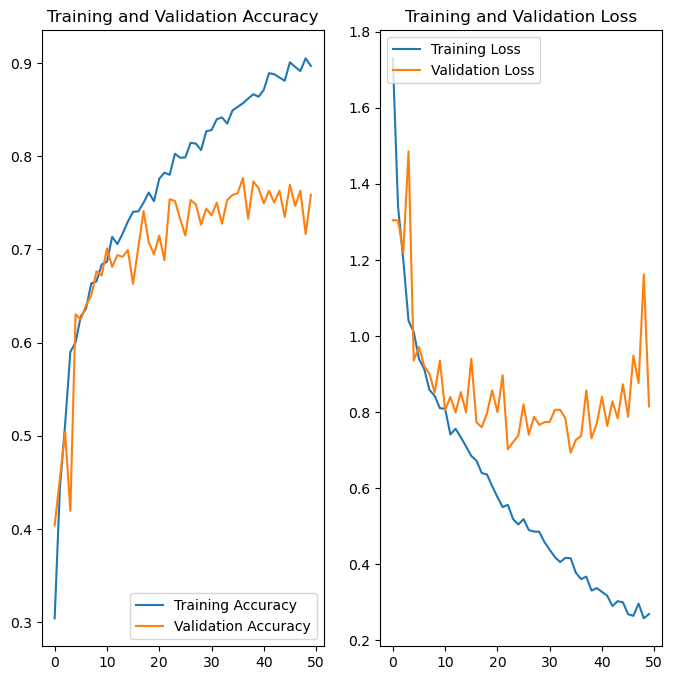

In [128]:
plot_accuracy_loss(history_alexnet_aug_dropout_model, 50)

1/1 [==============================] - 0s 28ms/step


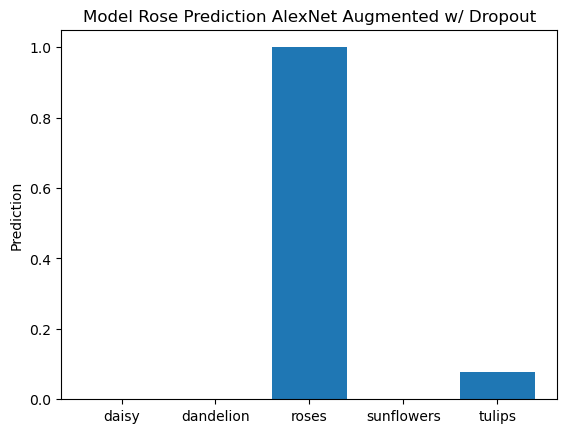

In [145]:
alexnet_aug_dropout_pediction = get_new_image_predictions(model_alexnet_aug_dropout, img_arr)
plot_rose_predictions(alexnet_aug_dropout_pediction, class_names, 'AlexNet Augmented w/ Dropout')


In [165]:
df_alexnet = pd.DataFrame([
    model_alexnet_score_dict,
    model_alexnet_aug_score_dict,
    model_alexnet_aug_dropout_score_dict]
)
row_names = {
    0:'AlexNet',
    1:'AlexNet Augmented',
    2:'AlexNet Augmented Dropout'
}
df_alexnet.rename(index=row_names, inplace=True)
df_alexnet

,loss,accuracy,binary_accuracy,categorical_accuracy,categorical_crossentropy
AlexNet,2.426010,0.715713,0.887012,0.715713,2.426010
AlexNet Augmented,1.014504,0.746594,0.901544,0.746594,1.014504
AlexNet Augmented Dropout,0.815250,0.758401,0.903906,0.758401,0.815250
